## Este es un Análisis Exploratorio de Datos y modelo de regresión aplicado a House Price

El proyecto se realizó a través de los siguientes pasos:
    
1. **Análisis exploratorio de datos**
    * 1.1 Exploración general
    * 1.2 Features Numericas
        * Exploración y limpieza de feature numéricas.
        * Datos faltante de features numéricos
    * 1.3 Features Categóricas
        * Exploración y limpieza de features categóricos
        * Datos faltantes de features categóricas.
        * Transformación de features categóricas en features binarias (get dummies)
    * 1.4 Combinaciones de variables numéricas y binarias en un conjunto de datos
    * 1.5 Eliminación de outliers desde el dataset train

2. **Ingeniería de caracteristicas**

3. **Preparacion de datos para el modelamiento**
    * 3.1 Variable objetivo 'SalesPrice'
    * 3.2 Cortando datos dentro de train y test estandarizados
    * 3.3 Regresión por pasos hacia atrás (Backward Stepwise Regression)
    * 3.4 Factor de inflación de varianza
    * 3.5 Cook distance
4. **Modelamiento**
    * 4.1 Modelos y métricas de selección
    * 4.2 Ajuste de parámetros y optimización del modelo
        * Ridge Regression
        * Lasso Regression
        * XGBoost Regression
        * LightGBM Regression
    * 4.3 Elección del mejor modelo
    * 4.4 Predicción sobre el dataset de testing test


#### Datasets:
El dataset train y test son importados desde la competición de Kaggle "House Price - Advanced Regression Techniques"

#### objetivo:
El obtjetivo de este kernel es elegir el mejor modelo de regresion que se ajuste al problema. Por lo tanto este proyecto empezará por la limpieza de datos, procesamiento de datos faltantes, selección de variables relevantes, deducción de algunos features, ejecución de pruebas estadísticas, definición de modelos de regresión y finalmente elejir el mejor modelo de predicción de precios en el dataset test.

# 1. Análisis exploratorio de Datos

Este análisi exploratorio e ingeniría de características son principalmente basadas en estos núcleos de Kaggle:
* [Comprehensive data exploration with python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python)

* [Detailed exploratory data analysis with python](https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python)

* [House price just with categorical features](https://www.kaggle.com/code/hosseinbehjat/house-price-just-with-categorical-features)

* [Handling missing values](https://www.kaggle.com/code/dansbecker/handling-missing-values)

### 1.1. Exploración general

#### Importamos y cargamos las librerías necesarias para el análisis de nuestros datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as norm

import missingno as msno
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

Cargamos los datasets:
* train.csv
* test.csv

In [2]:
df_train = pd.read_csv('Datasets/train.csv')
df_test = pd.read_csv('Datasets/test.csv')

#Imprimimos su dimensios o forma
print(f'Shape de train:\n {df_train.shape}')
print(f'Shape de test:\n {df_test.shape}')

Shape de train:
 (1460, 81)
Shape de test:
 (1459, 80)


Observamos la información de cada una de las variables de nuestros dataframes

In [3]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Se puede notar que muchas columnas tienen missing values (valores faltantes), los cuales trataremos mas adelante. 

#### Ahora vamos a comprobar si los encabezados de las columnas son los mismos en ambos dataframes df_train y df_test 

In [4]:
# List COmprehension
dif_1 = [x for x in df_train.columns if x not in df_test.columns]
dif_2 = [x for x in df_test.columns if x not in df_train.columns]

print("Las columnas presentes en df_train y ausentes en df_test son: ", dif_1, "\n")
print("Las columnas presentes en df_test y ausentes en df_train son: ", dif_2)

Las columnas presentes en df_train y ausentes en df_test son:  ['SalePrice'] 

Las columnas presentes en df_test y ausentes en df_train son:  []


Solo la columna o feature SalePrice es la que esta presente en el dataset df_train y no en el dataset df_train y eso es debido a que SalesPrices es la target variable u objetivo para ser predecida.

Normalmente el 80% de los datos se concentra en el dataset train (entrenamiento) y el 20% en dataset test (pruebas)

In [5]:
# Borramos el 'id' column desde el dataset train
df_train.drop(["Id"], axis = 1, inplace = True)

# Guardamos las lista de de "id" antes de elinar del dataset test
id_test_list = df_test['Id'].tolist()
df_test.drop(["Id"], axis = 1, inplace = True)


### 1.2. Features Numericas

#### Exploración y limpieza de features o variables numéricas

Seleccionamos las columnas del dataset de entrenamiento (train) con datos numéricos

In [6]:
# Guardamos en una nueva variable llamada df_train_num e imprimimos
df_train_num = df_train.select_dtypes(exclude = object)
df_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


En total son 37 columnas que contienen variables numéricas

Borramos columnas cuasi-constantes donde el 95% de valores son cuasiconstantes o similares.

In [7]:
# Creamos un objeto para elimininar columnas donde el 95% son constantes
sel = VarianceThreshold(threshold=0.05) 

# El método Fit encuentra las columnas con varianza constante
sel.fit(df_train_num.iloc[:,:-1])

# Se obtiene el numero de columnas que no son constantes
print('Número de features retenidas: ', sum(sel.get_support()))
print(f'Número de features cuasiconstantes: {len(df_train_num.iloc[:,:-1].columns) - sum(sel.get_support())}')

quasi_constant_features_list = [x for x in df_train_num.iloc[:, :-1].columns if x not in df_train_num.iloc[:, :-1].columns[sel.get_support()]]

print('Columnas cuasi constantes que son eliminadas: ', quasi_constant_features_list)

# Eliminamos estas columnas de df_train_num
df_train_num.drop(quasi_constant_features_list, axis = 1, inplace = True)

Número de features retenidas:  35
Número de features cuasiconstantes: 1
Columnas cuasi constantes que son eliminadas:  ['KitchenAbvGr']


Graficamos la distribución de todos los features numéricos

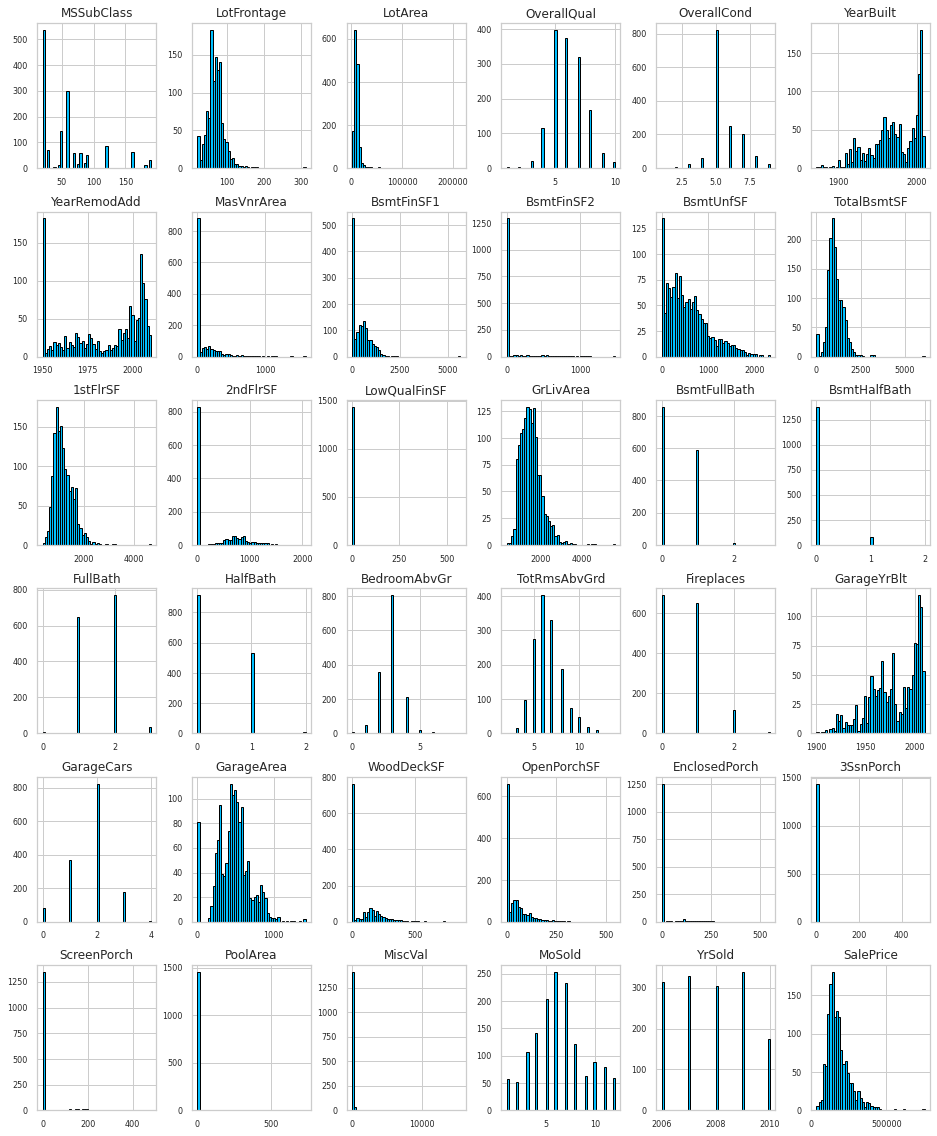

In [8]:
fig = df_train_num.hist(figsize = (16,20), bins = 50, color='deepskyblue',
                        edgecolor = 'black', xlabelsize = 8, ylabelsize = 8)

Graficamos un Heatmap para todas las variables numéricas incluyendo el target 'SalePrices'

<AxesSubplot:>

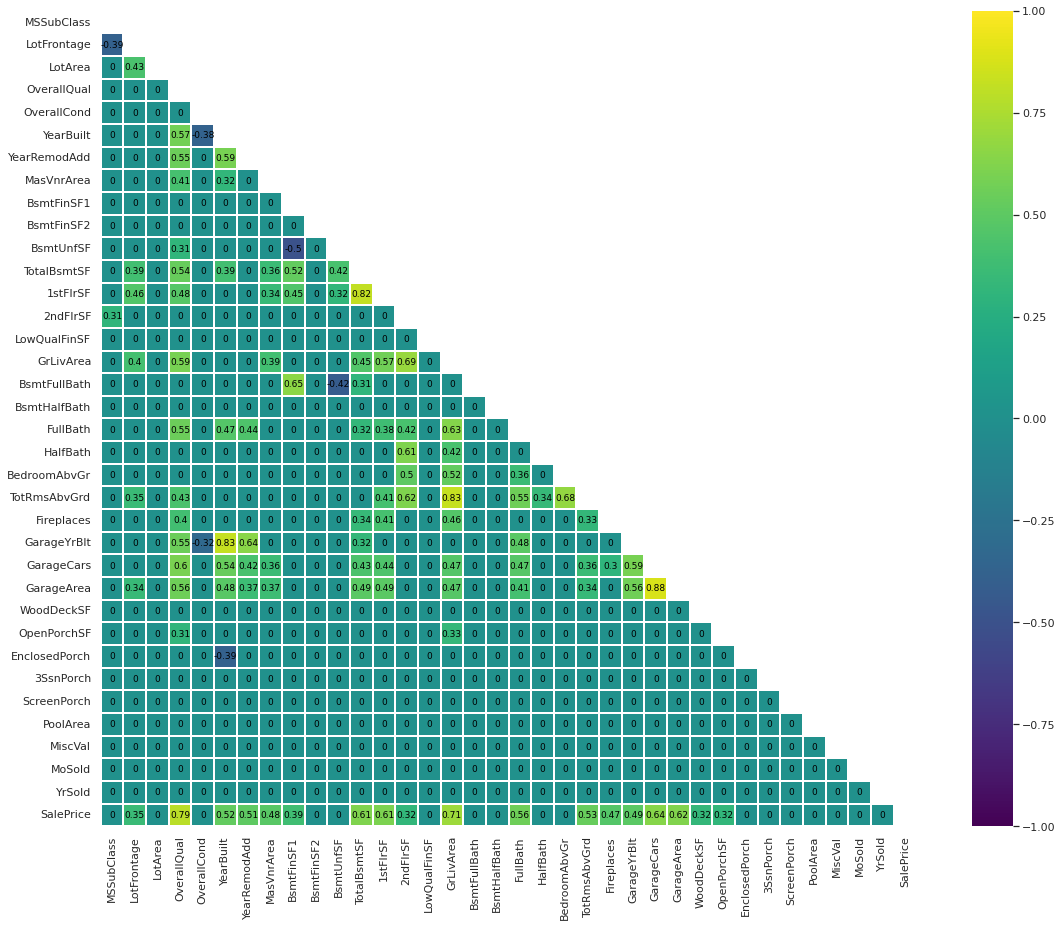

In [9]:
# Definiendo los parámetros de Heatmap
pd.options.display.float_format = "{:,.2f}".format

# Definimos la matriz de correlación
corr_matrix = df_train_num.corr()

# Reemplazamos las correlaciones menos que |0.3| por 0 para una mejor visibilidad
corr_matrix[(corr_matrix<0.3)&(corr_matrix>-0.3)] = 0

# Cubro las parte superior del Heatmap o mapa de calor
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Elejimos el color del mapa
cmap = "viridis"

# Graficamos el heatmap
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
           annot_kws={"size":9,"color": "black" }, square=True, cmap=cmap, annot=True)


A partir de la distribución de cada variable numérica así como la del Heatmap podemos notar que son importantes 18 features y están correlacionadas sin nuestra variable target 'SalesPrices' 

También podemos observar que muchas features está correlacionadas entre sí.Manejaremos éstas correlaciones mientras seleccionados las características para nuestro modelo.

In [10]:
# Seleccionamos features donde la correlación con 'SalePrice' es mayor que |0.3|. Es -1 porque la última columna es 'SalePrice'
df_num_corr = df_train_num.corr()['SalePrice'][:-1]

# Features correlacinadas (r2 > 0.5)
hight_features_list= df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending = False)

print(
f"{len(hight_features_list)} valores fuertemente correlacionados con 'SalePrice: \n{hight_features_list}\n'"
)

# Features correlacioadas (0.3 < r2 > 0.5)
low_features_list = df_num_corr[(abs(df_num_corr)<0.5) & (abs(df_num_corr)>=0.3)].sort_values(ascending=False)

print(
f"{len(low_features_list)} valores suavemente correlacionados con 'SalePrice: \n{low_features_list}\n'"
)

10 valores fuertemente correlacionados con 'SalePrice: 
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64
'
8 valores suavemente correlacionados con 'SalePrice: 
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64
'


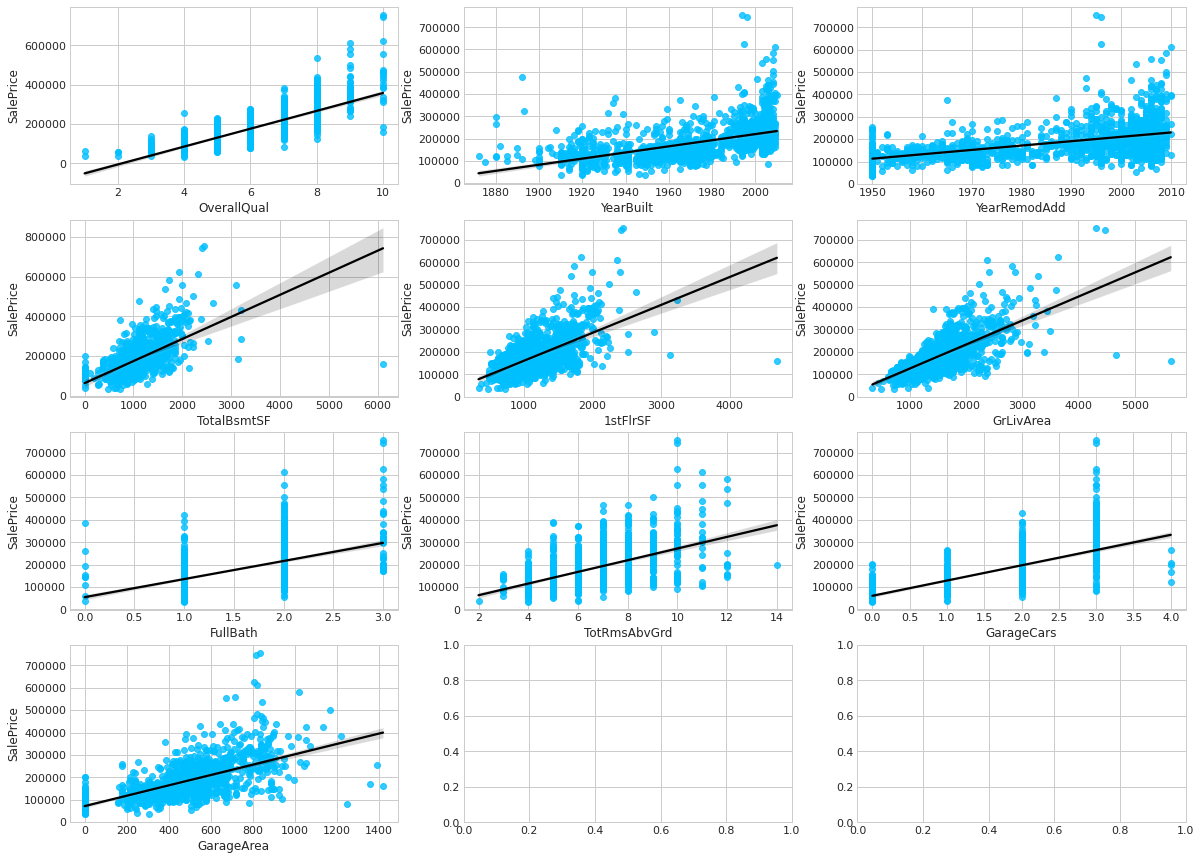

In [11]:
# Features con una alta correlación (mayor que 0.5)
strong_features = df_num_corr[abs(df_num_corr)>0.5].index.tolist()
# Añado el nombre de la target 'SalePrice'
strong_features.append('SalePrice')

# Defino un dataFrame con los features fuertemente correlacionados
df_strong_features = df_train_num.loc[:, strong_features]

# Defino un estilo para las figuras
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(round(len(strong_features)/3), 3)


for i, ax in enumerate(fig.axes):
    # Graficamos la correlación de cada feature con SalePrice. Recuerde que strong_feature es una lista
    if i < len(strong_features)-1:
        sns.regplot(x=strong_features[i], y="SalePrice", data=df_strong_features, ax=ax, scatter_kws={
                    "color": "deepskyblue"}, line_kws={"color": "black"})

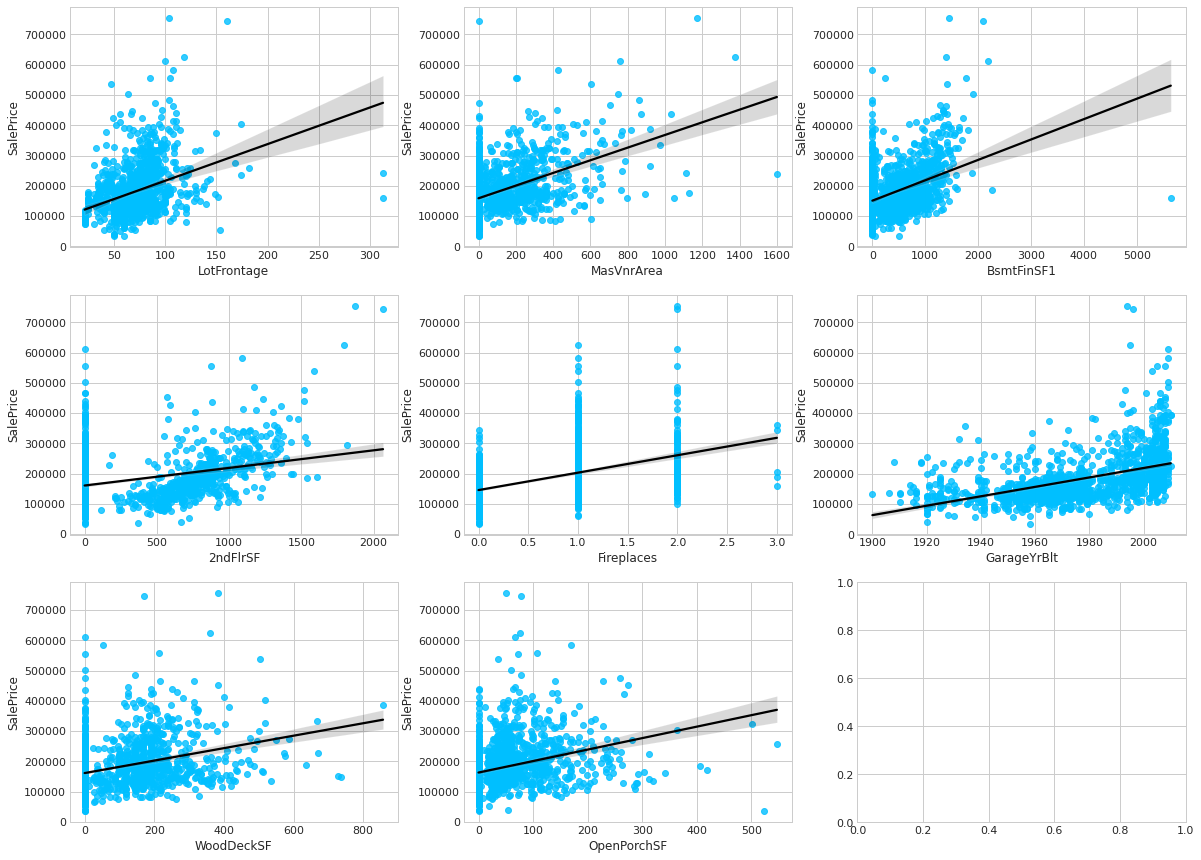

In [12]:
# Features con bajas correlaciones entre 0.3 y 0.5
low_features = df_num_corr[(abs(df_num_corr)>=0.3) & (abs(df_num_corr)<0.5)].index.tolist()
# Añadimos también SalesPrice
low_features.append('SalePrice')

# Definimos un dataFrame con los features encontrados con los datos
df_low_features = df_train_num.loc[:, low_features]

# Defino un estilo para las figuras
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(round(len(low_features)/3), 3)

for i, ax in enumerate(fig.axes):
    # Graficamos la correlación de cada feature con SalePrice. Recuerde que low_feature es una lista
    if i < len(low_features)-1:
        sns.regplot(x=low_features[i], y="SalePrice", data=df_low_features, ax=ax, scatter_kws={
                    "color": "deepskyblue"}, line_kws={"color": "black"})



In [13]:
# Definimos la lista de features numéricos a mantener
list_of_numerical_features = strong_features[:-1] + low_features

# Definimos nuestro nuevo data set de entrenamiento con las features seleccionadas
df_train_num = df_train_num.loc[:, list_of_numerical_features]

# Definimos nuestro nuevo data set de pruebas igualmente con las features seleccionadas (-1 excepto 'SalesPrice')
df_test_num = df_test.loc[:, list_of_numerical_features[:-1]]

Se mantuvo las 18 features más correlacionadas con 'SalesPrice'

### Datos Faltantes de features numéricas

Se chequeará los NaN del set de entrenamiento dibujando el porcentaje de valores faltantes por columna

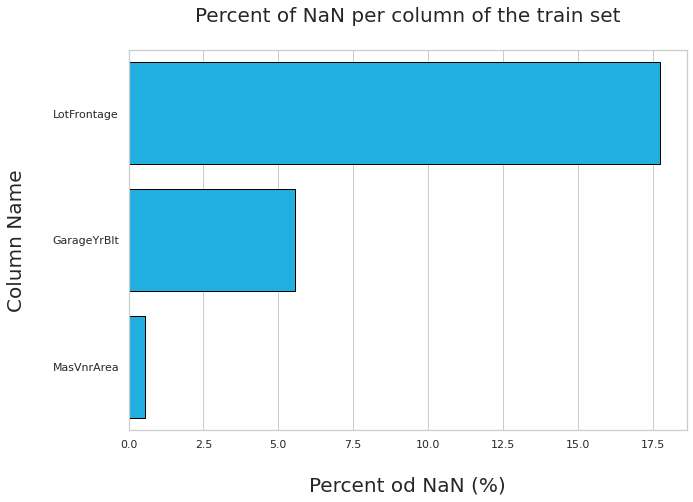

In [14]:
# Determino que columnas o features presentan valores NaN
column_with_nan = df_train_num.columns[df_train_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    # Sumo la cantidad de NaN por columna multilplico por cien y divido para la longitud total de la columna
    percent_nan.append(round(df_train_num[i].isnull().sum()*100/len(df_train_num), 2))

# Creamos un Dataframe con las colunmnas con valores NaN y sus respectivos porcentajes de valores NaN    
tab = pd.DataFrame(column_name, columns=['Column'])
tab['Percent_NaN'] = percent_nan
tab.sort_values(by = ['Percent_NaN'], ascending=False, inplace = True)


# Definios parametros de figura
sns.set(rc={"figure.figsize":(10,7)})
sns.set_style("whitegrid")

# Graficamos resultados
p = sns.barplot("Percent_NaN", y = "Column", data = tab,
                edgecolor = 'black', color = 'deepskyblue')

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent od NaN (%)", fontsize = 20)
p.set_ylabel("Column Name\n", fontsize = 20)
plt.show()


Imputación de valores faltantes NaN's con SimpleImputer

In [15]:
# Creamos un objeto de tipo SimpleImputer
my_imputer = SimpleImputer(strategy="median")

# Imputo el dataset df_train_num y defino un nueo dataset 
df_train_imputed = pd.DataFrame(my_imputer.fit_transform(df_train_num))

# Reescribo columnas 
df_train_imputed.columns = df_train_num.columns

# Miramos si ahora existen valores falatantes
df_train_imputed.isnull().sum()


OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
2ndFlrSF        0
Fireplaces      0
GarageYrBlt     0
WoodDeckSF      0
OpenPorchSF     0
SalePrice       0
dtype: int64

Chequemos la distribución de cada features antes y después de la imputación

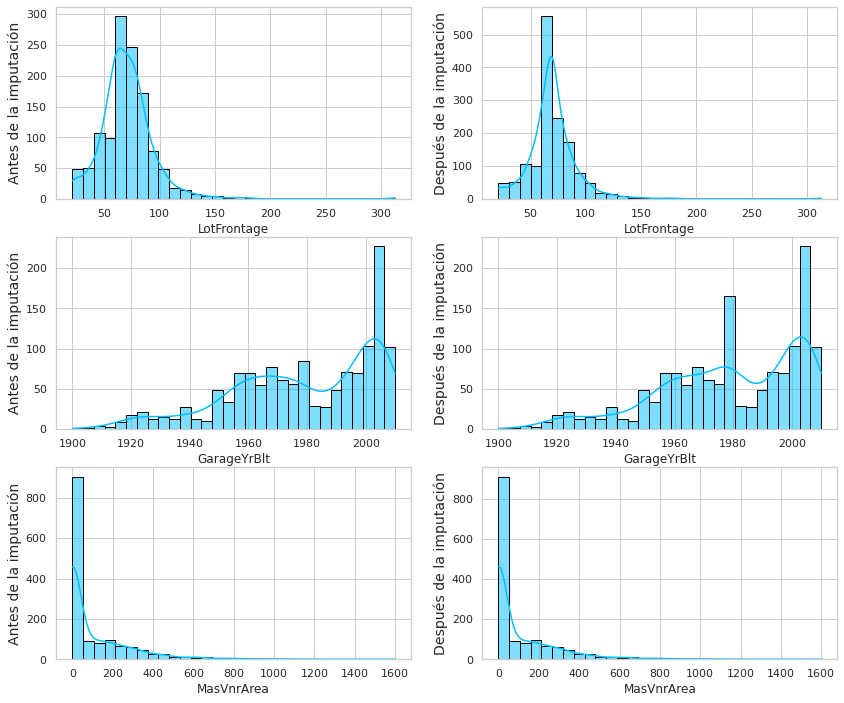

In [16]:
# Definimos los parámetros de la figura
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3,2)

# Graficamos los resultados
for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0,1,2]):
    
    """ Ditribución de features antes y depués de la imputación"""
    
    # Antes la imputación
    p = sns.histplot(ax = axes[fig_pos, 0], x = df_train_num[feature],
                    kde = True, bins=30, color = "deepskyblue", edgecolor = "black" )
    p.set_ylabel(f'Antes de la imputación', fontsize=14)
    
    # después de la imputación
    q = sns.histplot(ax = axes[fig_pos,1], x=df_train_imputed[feature],
                     kde = True, bins=30, color = "deepskyblue", edgecolor = "black" )
    q.set_ylabel(f'Después de la imputación', fontsize=14) 

Para "LotFrontage", "GarageYrBlt" las distribuciones han cambiado después de la distribución. Pero no es así para la distribución de "MasVnrArea". Entonces se eliminarán las features que muestran cambios para evitar errores relacionadosa a la imputación y solo mantendrá "MasVnrArea" para el análisis. 

In [17]:
# Borramos "LotFrontage" y "GarageYrBlt"
df_train_imputed.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace = True)
df_train_imputed.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,Fireplaces,WoodDeckSF,OpenPorchSF,SalePrice
0,7.00,"2,003.00","2,003.00",856.00,856.00,"1,710.00",2.00,8.00,2.00,548.00,196.00,706.00,854.00,0.00,0.00,61.00,"208,500.00"
1,6.00,"1,976.00","1,976.00","1,262.00","1,262.00","1,262.00",2.00,6.00,2.00,460.00,0.00,978.00,0.00,1.00,298.00,0.00,"181,500.00"
2,7.00,"2,001.00","2,002.00",920.00,920.00,"1,786.00",2.00,6.00,2.00,608.00,162.00,486.00,866.00,1.00,0.00,42.00,"223,500.00"
3,7.00,"1,915.00","1,970.00",756.00,961.00,"1,717.00",1.00,7.00,3.00,642.00,0.00,216.00,756.00,1.00,0.00,35.00,"140,000.00"
4,8.00,"2,000.00","2,000.00","1,145.00","1,145.00","2,198.00",2.00,9.00,3.00,836.00,350.00,655.00,"1,053.00",1.00,192.00,84.00,"250,000.00"


Test dataset

Las columnas que han sido borradas en el set de entranemiento (train) también deben ser borradas en el set de prueba (test), para que los dos modelos permanezcan idénticos para el modelado y predicción.

In [18]:
# Borramos las mismas feutures "LotFrontage" y "GarageYrBlt" para nuestro set test
df_test_num.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace = True)

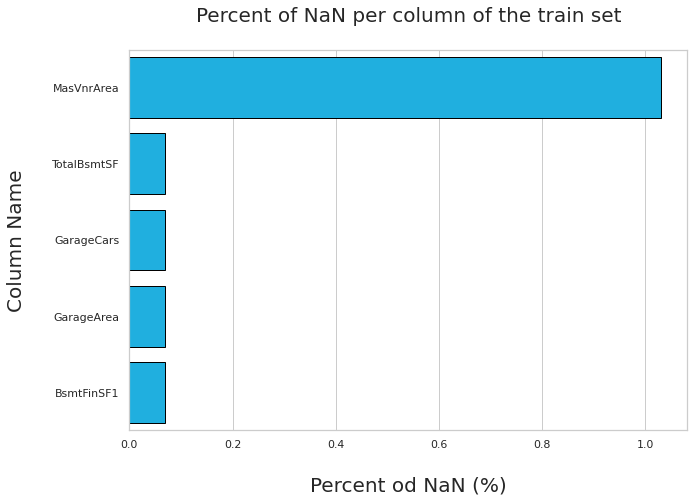

In [19]:
# chequeamos los NaN del set test para graficar el porcentaje de valores faltantes por columna
column_with_nan = df_test_num.columns[df_test_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    # Sumo la cantidad de NaN por columna multilplico por cien y divido para la longitud total de la columna
    percent_nan.append(round(df_test_num[i].isnull().sum()*100/len(df_test_num), 2))

# Creamos un Dataframe con las colunmnas con valores NaN y sus respectivos porcentajes de valores NaN    
tab = pd.DataFrame(column_name, columns=['Column'])
tab['Percent_NaN'] = percent_nan
tab.sort_values(by = ['Percent_NaN'], ascending=False, inplace = True)


# Definios parametros de figura
sns.set(rc={"figure.figsize":(10,7)})
sns.set_style("whitegrid")

# Graficamos resultados
p = sns.barplot("Percent_NaN", y = "Column", data = tab,
                edgecolor = 'black', color = 'deepskyblue')

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent od NaN (%)", fontsize = 20)
p.set_ylabel("Column Name\n", fontsize = 20)
plt.show()

Imputamos datos faltantes

In [20]:
# Realizamos la imputación de los valores faltantes con SimpleImputer
my_imputer = SimpleImputer(strategy="median")

# Imputo el dataset df_train_num y defino un nueo dataset 
df_test_imputed = pd.DataFrame(my_imputer.fit_transform(df_test_num))

# Reescribo columnas 
df_test_imputed.columns = df_test_num.columns

# Miramos si ahora existen valores falatantes
df_test_imputed.isnull().sum()



OverallQual     0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
GarageCars      0
GarageArea      0
MasVnrArea      0
BsmtFinSF1      0
2ndFlrSF        0
Fireplaces      0
WoodDeckSF      0
OpenPorchSF     0
dtype: int64

Chequeamos las distribuciones de cada distribución antes y después de la imputación

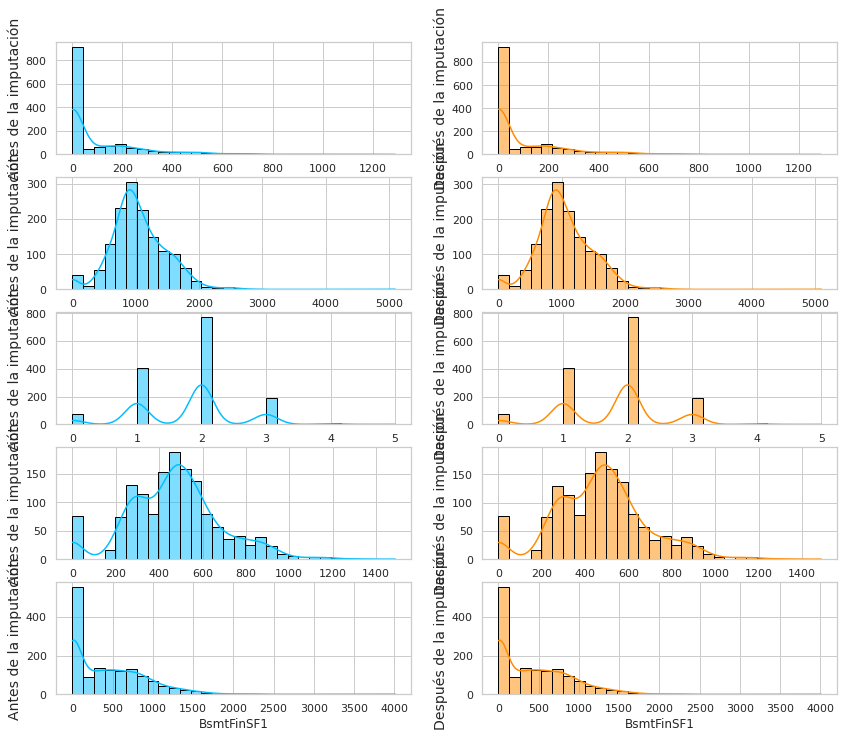

In [21]:
# Definimos los parámetros de la figura
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(5,2)

# Graficamos los resultados
for feature, fig_pos in zip(tab['Column'].tolist(), range(0,6)):
    
    """ Ditribución de features antes y depués de la imputación"""
    
    # Antes la imputación
    p = sns.histplot(ax = axes[fig_pos, 0], x = df_test_num[feature],
                    kde = True, bins=30, color = "deepskyblue", edgecolor = "black" )
    p.set_ylabel(f'Antes de la imputación', fontsize=14)
    
    # después de la imputación
    q = sns.histplot(ax = axes[fig_pos,1], x=df_test_imputed[feature],
                     kde = True, bins=30, color = "darkorange", edgecolor = "black" )
    q.set_ylabel(f'Después de la imputación', fontsize=14)

Los porcentajes de NaN en cada uno de esto features no excede el 1.5%.Por lo tanto al imputar estos errores faltantes, pocos errores fueron introducidos y las distribucione fueron similares antes y después de la imputación.

### Features categóricas

#### Exploración y limpieza de features categóricas

In [22]:
# Relación categórica a cuantitativa. Se usa una lista coprehensin
categorical_features = [i for i in df_train.columns if df_train.dtypes[i] == 'object' ]
categorical_features.append('SalePrice')

# Creamos el set de entrenamieno de features categoricas.
df_train_categ = df_train[categorical_features]

# Creamos al mismo tiempo el set de pruebas de features categóricas
df_test_categ = df_test[categorical_features[:-1]]

Contamos cada una de las features categórcas en el set de entrenamiento categórico

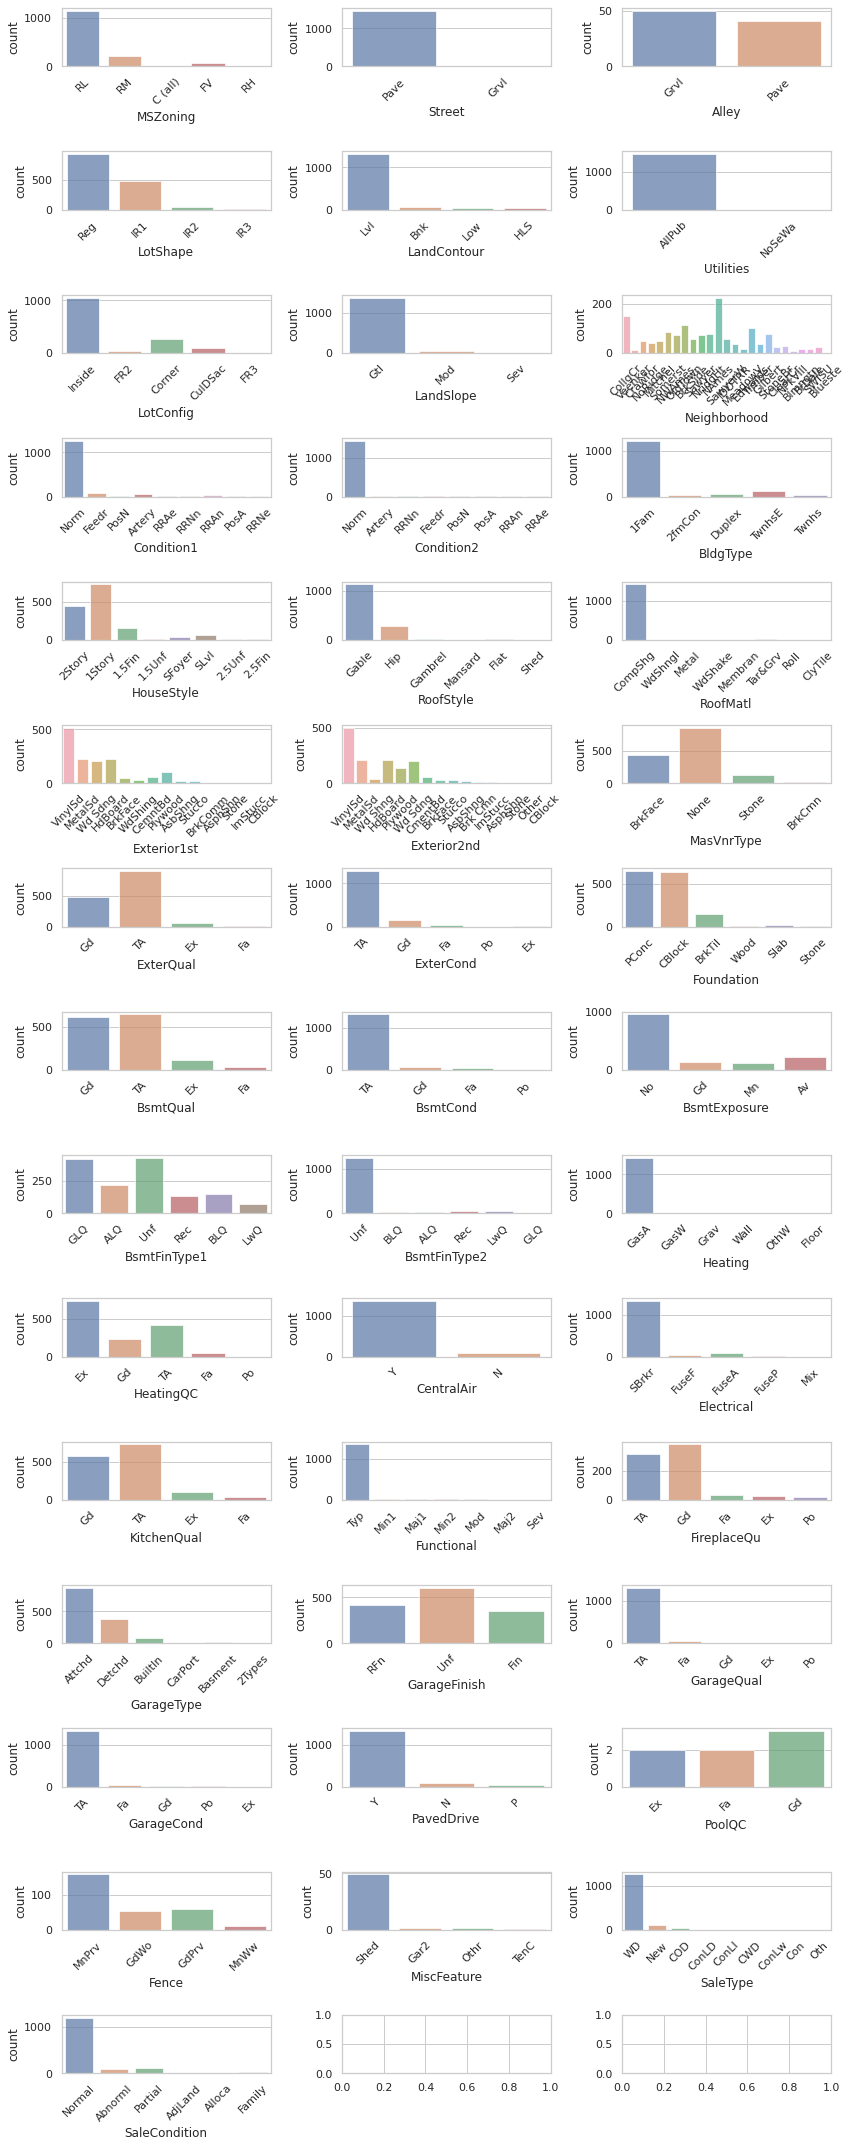

In [23]:
fig, axes = plt.subplots( round(len(df_train_categ.columns)/3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    # Graficamos un barplot para cada features
    if i < len(df_train_categ.columns)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation = 45)        
        sns.countplot(x=df_train_categ.columns[i], alpha = 0.7, data = df_train_categ, ax=ax)
        
fig.tight_layout()
        

Mirando cernamente algunos de los count plots se puede notar que algunas de las features categorias las observaciones están concentradas en un único nivel de categoría. Estas características son menos informaticas para nuestro modelo de modo que sería mejor removerlas.

In [24]:
# Eliminamos algunas de las caractecrísticas NO informativas del set de entrenamiento (set train)
columns_to_drop = [
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LandSlope",
    "Condition2",
    "RoofMatl",
    "CentralAir",
    "GarageQual",
    "GarageCond",
    "SaleType",
    "PavedDrive",
    "LandContour",
    "ExterCond",
    "GarageCond",
    "Heating",
    "MiscFeature",
    "BsmtFinType2",
    "Functional",
    "GarageQual",
    "GarageCond",
]

# Set de entrenamiento
df_train_categ.drop(columns_to_drop, axis = 1, inplace = True)
 
# Set de pruebas
df_test_categ.drop(columns_to_drop, axis = 1, inplace=True)

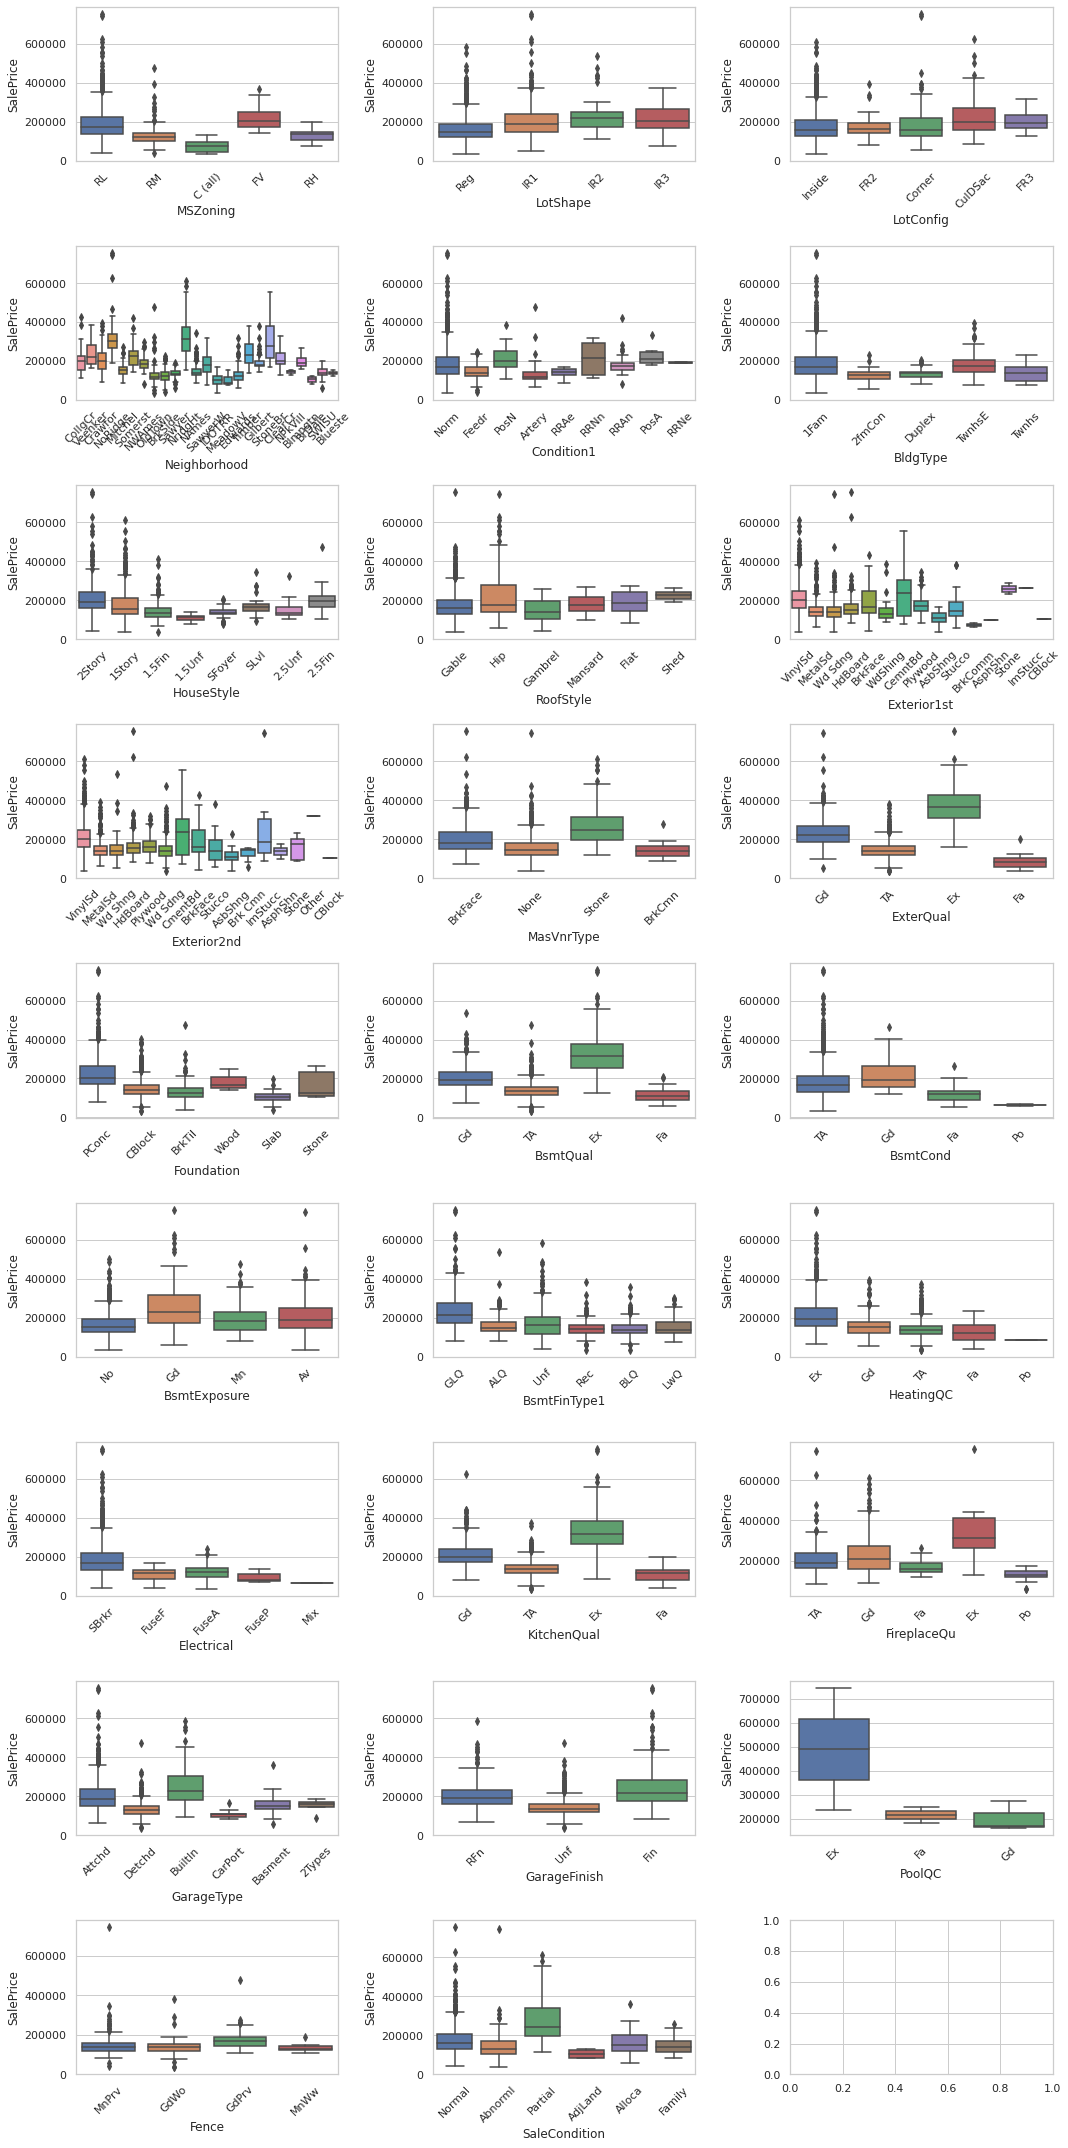

In [25]:
# Con boxplot podemos ver la variación de nuestro target 'SalePrice' en cada una de las variables categóricas.
fig, axes = plt.subplots(round(len(df_train_categ.columns)/3), 3, figsize = (15,30))

for i , ax in enumerate(fig.axes):
    # Variación de 'SalePrices' en cada feature categórica
    if i<len(df_train_categ.columns)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(x=df_train_categ.columns[i], y="SalePrice", data=df_train_categ, ax=ax)

fig.tight_layout()


Algunos de estos features parecen ser codependientes tales como  'Exterior1st' & 'Exterior2nd', 'BsmtQual' & 'BsmtCond', 'MasVnrType' & 'ExterQual' etc. Entonces gráfiquemos tablas de contigencia para relzar el test de Chi cuadrado e identificar éstas codependencias.

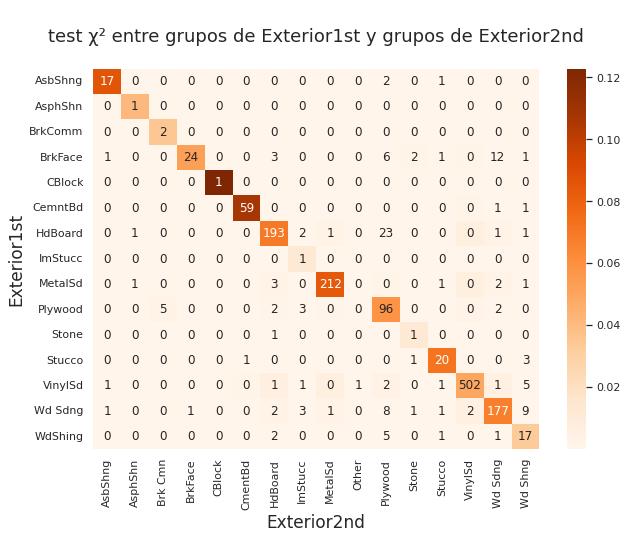

Valor-P del ChiSq Test entre Exterior1st y Exterior2nd es: 0.0



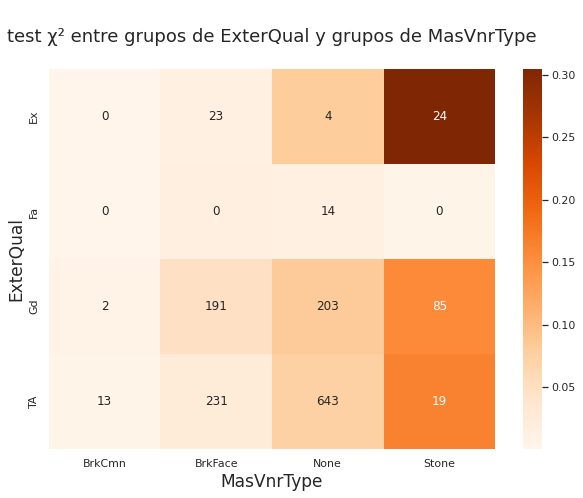

Valor-P del ChiSq Test entre ExterQual y MasVnrType es: 1.0187554679218715e-54



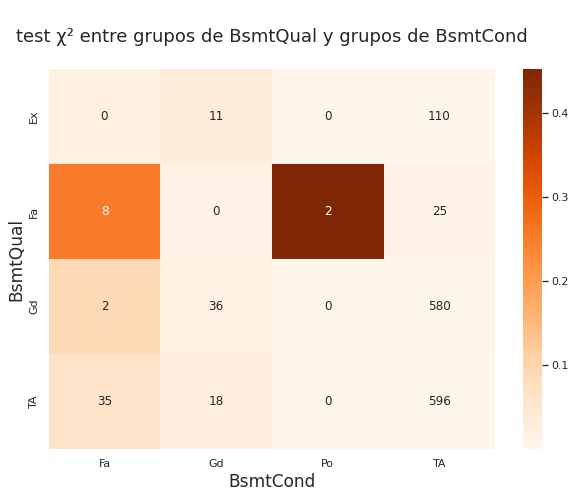

Valor-P del ChiSq Test entre BsmtQual y BsmtCond es: 1.9371809126533347e-31



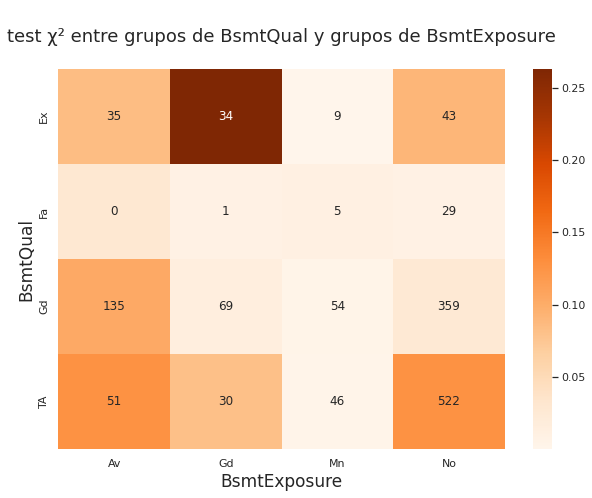

Valor-P del ChiSq Test entre BsmtQual y BsmtExposure es: 3.879215036512606e-32



In [31]:
# Graficamos las tablas de contingencia
# Establecemos en el tamaño de la figura
sns.set(rc={"figure.figsize": (10,7)})

#Definimos las variables
X = ["Exterior1st", "ExterQual", "BsmtQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtCond", "BsmtExposure"]

for i,j  in zip(X,Y):
    # Contingency table
    cont =  df_train_categ[[i,j]].pivot_table(index = i, columns = j, aggfunc = len, margins = True, margins_name="Total")
    
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n=len(df_train_categ)
    indep = tx.dot(ty)/n
    
    c = cont.fillna(0)
    measure = (c-indep)**2/indep
    x1_n = measure.sum().sum()
    table = measure/x1_n
    
    # Graficamos la contgency table 
    p = sns.heatmap(table.iloc[:-1, :-1], annot = c.iloc[:-1,:-1], fmt = ".0f", cmap="Oranges")
    
    p.set_xlabel(j, fontsize = 17)
    p.set_ylabel(i, fontsize = 17)
    p.set_title(f"\ntest χ² entre grupos de {i} y grupos de {j}\n", size=18)
    plt.show()
    
    # Realizamos test Chi square
    CrosstabResult = pd.crosstab(index = df_train_categ[i], columns = df_train_categ[j])
    
    ChiSqResult = chi2_contingency(CrosstabResult)
    
    # P-value es la probabilidad de Ho sea Verdad
    print(f"Valor-P del ChiSq Test entre {i} y {j} es: {ChiSqResult[1]}\n")  

El valor P es significante para todos los test, de modo que hay codependecia entre estas variables. Por ésta razón eliminarremos las features 'Exterior2nd', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' y 'MasVnrType'. 

In [33]:
# Eliminamos cada una de las variables codependientes.
#datos de Train
df_train_categ.drop(Y, axis=1, inplace=True)

#datos en Test
df_test_categ.drop(Y, axis=1, inplace=True)

#### Datos faltantes en features categóricas

Train set

Text(0, 0.5, 'Colums Name\n')

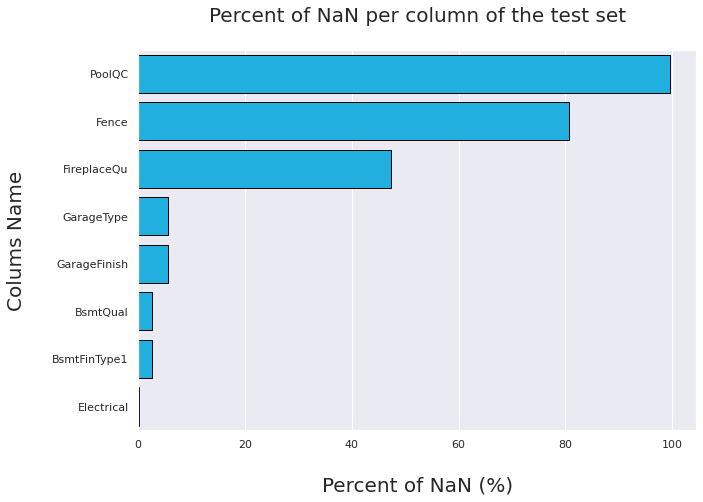

In [36]:
# Chequeamo los NaN del test dataset para graficar el porcentaje de valores faltantes por columna
column_with_nan = df_train_categ.columns[df_train_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(round(df_train_categ[i].isnull().sum()*100/len(df_train_categ), 2))
    
tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by = ["Percent_NaN"], ascending=False, inplace=True)

# Definimos parámetros de figura 
p = sns.barplot(x= "Percent_NaN",  y = "Column", data = tab,
                edgecolor = "black", color = "deepskyblue")

p.set_title("Percent of NaN per column of the test set\n", fontsize = 20)
p.set_xlabel("\nPercent of NaN (%)", fontsize = 20)
p.set_ylabel("Colums Name\n", fontsize=20)   


Se eliminarán las fatures donde el porcentaje de NaN es mayor al 5% para evitar introducir algún error. Es mejor que imputar NaN de  'BsmtQual' y 'Electrical por la correspondiente clase modal. 

In [37]:
# Elimiminamos los features donde el porcentaje de NaN es mayor al 5%
df_train_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                     "GarageType", "GarageFinish"],axis = 1, inplace=True)

In [42]:
# Llenamos los NaN de cada features para la correspondiente clases modal
categ_fill_null = {"BsmtQual": df_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_train_categ["BsmtFinType1"].mode().iloc[0],
                   "Electrical": df_train_categ["Electrical"].mode().iloc[0]}

df_train_categ = df_train_categ.fillna(value=categ_fill_null)

#### Test Set